In [71]:
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Define a function to create the model for our CNN. The input consists of images shaped 16x15 pixels each. The initial model consists of a single convolutional layer, followed by a max pooling layer, then a flattening layer, ending with two fully connected layers.

In [131]:
def define_model():
    input_shape = (16, 15, 1)
    model = Sequential([
        Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same', input_shape = input_shape),
        MaxPool2D(pool_size = 2),
        Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same'),
        MaxPool2D(pool_size = 2),
        Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'),
        MaxPool2D(pool_size = 2),
        Flatten(),
        Dense(units = 64, activation = 'relu'),
        Dense(units = 10, activation = 'softmax')
    ])
    return model

In [132]:
def compile_model(model):
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [133]:
def train_model(model, x, y, epochs):
    model.fit(x, y, shuffle = True, epochs = epochs)

In [134]:
def load_data(): 
    raw_data = []
    with open('./ProjectDigits_materials/mfeat-pix.txt', 'r') as f:
        for line in f:
            pixels = []
            for c in line:
                if c.isdigit():
                    pixels.append(int(c))
            raw_data.append(pixels)
    raw_data = np.array(raw_data)
    return raw_data

In [135]:
def normalize_data(data):
    data.astype(float)
    return data / 6

In [136]:
data = load_data()
data = normalize_data(data)
data.shape

(2000, 240)

In [137]:
def n_image_in_category(data) -> int:
    return int(data.shape[0] / 10)

In [138]:
# split the data into train and test sets
n_images = n_image_in_category(data)
split = int(n_images / 2)

#random split
# split_indices = [row * n_images + np.random.choice(n_images, split, replace=False) for row in range(10)]

# real split
split_indices = [np.arange(i * 200, i * 200 + 100) for i in range(10)]

split_indices = np.array(split_indices).flatten()
train_data = data[split_indices]
test_data = np.delete(data, split_indices, axis=0)

In [139]:
#sanity checks
assert (n_images == 200 and split == 100)
assert (train_data.shape == test_data.shape == (1000, 240))

In [140]:
# Reshape variables to (16 x 15 x 1)
train_data = train_data.reshape(train_data.shape[0], 16, 15, 1)
test_data = test_data.reshape(test_data.shape[0], 16, 15, 1)

# Create train- and test labels, then use one-hot encoding on them
train_images = n_image_in_category(train_data)
train_labels = np.zeros((train_data.shape[0], 10), dtype=np.int64)
for i in range(10):
    for j in range(train_images):
        train_labels[i * train_images + j, i] = 1

test_images = n_image_in_category(test_data)
test_labels = np.zeros((test_data.shape[0], 10), dtype=np.int64)
for i in range(10):
    for j in range(test_images):
        test_labels[i * test_images + j, i] = 1

In [141]:
model = define_model()
compile_model(model)

In [142]:
# Apply k-fold validation using the train data only
k = 50
fold = 1

acc_per_fold = []
loss_per_fold = []

kfold = KFold(n_splits = k)

for train, test in kfold.split(train_data, train_labels):
    print(f'Training fold {fold}')
    history = model.fit(
        train_data[train], 
        train_labels[train], 
        batch_size = 10, 
        epochs = 25
    )
    scores = model.evaluate(train_data[test], train_labels[test], verbose = 0)
    print(f'Score for fold {fold}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold += 1

Training fold 1
Epoch 1/25
98/98 [==============================] - 1s 3ms/step - loss: 1.4146 - accuracy: 0.5347
Epoch 2/25
98/98 [==============================] - 0s 3ms/step - loss: 0.2237 - accuracy: 0.9296
Epoch 3/25
98/98 [==============================] - 0s 2ms/step - loss: 0.1084 - accuracy: 0.9755
Epoch 4/25
98/98 [==============================] - 0s 2ms/step - loss: 0.0835 - accuracy: 0.9755
Epoch 5/25
98/98 [==============================] - 0s 3ms/step - loss: 0.0338 - accuracy: 0.9888
Epoch 6/25
98/98 [==============================] - 0s 3ms/step - loss: 0.0344 - accuracy: 0.9878
Epoch 7/25
98/98 [==============================] - 0s 3ms/step - loss: 0.0227 - accuracy: 0.9918
Epoch 8/25
98/98 [==============================] - 0s 3ms/step - loss: 0.0064 - accuracy: 0.9990
Epoch 9/25
98/98 [==============================] - 0s 3ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 10/25
98/98 [==============================] - 0s 3ms/step - loss: 0.0010 - accuracy: 1.0000
Epo

In [143]:
print('Score per fold')
for i in range(0, k):
    print(f'Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')

print('------------')
print(f'Average score for all folds: Loss: {np.mean(loss_per_fold)} - Accuracy: {np.mean(acc_per_fold)}%')

Score per fold
Fold 1 - Loss: 0.03942339867353439 - Accuracy: 94.9999988079071%
Fold 2 - Loss: 4.770540544996038e-05 - Accuracy: 100.0%
Fold 3 - Loss: 2.145751977877808e-06 - Accuracy: 100.0%
Fold 4 - Loss: 6.496891842289187e-07 - Accuracy: 100.0%
Fold 5 - Loss: 0.0 - Accuracy: 100.0%
Fold 6 - Loss: 2.3245797819981817e-07 - Accuracy: 100.0%
Fold 7 - Loss: 2.9802311729554276e-08 - Accuracy: 100.0%
Fold 8 - Loss: 3.576277407546513e-08 - Accuracy: 100.0%
Fold 9 - Loss: 0.0 - Accuracy: 100.0%
Fold 10 - Loss: 5.960463678178485e-09 - Accuracy: 100.0%
Fold 11 - Loss: 2.9802311729554276e-08 - Accuracy: 100.0%
Fold 12 - Loss: 0.0018059577560052276 - Accuracy: 100.0%
Fold 13 - Loss: 2.8014125064146356e-07 - Accuracy: 100.0%
Fold 14 - Loss: 1.6689284620952094e-07 - Accuracy: 100.0%
Fold 15 - Loss: 2.03844069801562e-06 - Accuracy: 100.0%
Fold 16 - Loss: 1.2099649211450014e-06 - Accuracy: 100.0%
Fold 17 - Loss: 0.0 - Accuracy: 100.0%
Fold 18 - Loss: 1.0132780658977936e-07 - Accuracy: 100.0%
Fold 19

These results indicate quite high performance, so we will retrain the same model with the full training dataset, then validate using the test set.

In [144]:
history = model.fit(
    train_data, 
    train_labels, 
    batch_size = 10, 
    epochs = 25
)

scores = model.evaluate(test_data, test_labels, verbose = 0)
print(f'Score for trained model: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')

Epoch 1/25
100/100 [==============================] - 0s 3ms/step - loss: 1.1444e-08 - accuracy: 1.0000
Epoch 2/25
100/100 [==============================] - 0s 2ms/step - loss: 9.8944e-09 - accuracy: 1.0000
Epoch 3/25
100/100 [==============================] - 0s 3ms/step - loss: 9.0599e-09 - accuracy: 1.0000
Epoch 4/25
100/100 [==============================] - 0s 2ms/step - loss: 8.5831e-09 - accuracy: 1.0000
Epoch 5/25
100/100 [==============================] - 0s 2ms/step - loss: 7.7486e-09 - accuracy: 1.0000
Epoch 6/25
100/100 [==============================] - 0s 2ms/step - loss: 7.1526e-09 - accuracy: 1.0000
Epoch 7/25
100/100 [==============================] - 0s 2ms/step - loss: 7.0333e-09 - accuracy: 1.0000
Epoch 8/25
100/100 [==============================] - 0s 2ms/step - loss: 6.6757e-09 - accuracy: 1.0000
Epoch 9/25
100/100 [==============================] - 0s 2ms/step - loss: 6.3181e-09 - accuracy: 1.0000
Epoch 10/25
100/100 [==============================] - 0s 2ms/st

In [145]:
model.save('cnn_digits_trained.model')

INFO:tensorflow:Assets written to: cnn_digits_trained.model\assets


INFO:tensorflow:Assets written to: cnn_digits_trained.model\assets


32/32 [==============================] - 0s 1ms/step


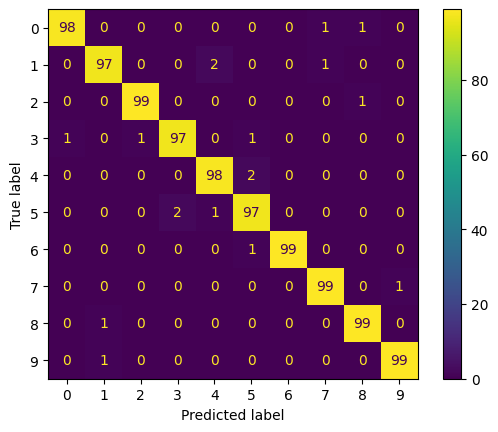

In [152]:
# Generate predictions, then compare to ground truth in a confusion matrix
predictions = model.predict(test_data)

predicted_labels = []
true_labels = []

for i in range(0, len(predictions)):
    predicted_labels.append(predictions[i].argmax())
    true_labels.append(test_labels[i].argmax())

conf_matrix = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
disp.plot().figure_.savefig('confmatrix.png')